In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


In [ ]:
stock_symbols = [
    'NTPC.NS', 'HDFCLIFE.NS', 'HINDALCO.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'TATASTEEL.NS', 'ULTRACEMCO.NS', 'CIPLA.NS', 'ITC.NS', 'BAJAJ-AUTO.NS', 'APOLLOHOSP.NS', 'ADANIENT.NS', 'BAJAJFINSV.NS', 'TITAN.NS', 'BRITANNIA.NS', 'NESTLEIND.NS', 'TATACONSUM.NS', 'BHARTIARTL.NS', 'RELIANCE.NS', 'BAJFINANCE.NS', 'ONGC.NS', 'COALINDIA.NS', 'WIPRO.NS', 'TECHM.NS', 'LT.NS', 'MARUTI.NS', 'TCS.NS', 'HEROMOTOCO.NS', 'INDUSINDBK.NS'

] #top 30 components that appeared in nifty50 in yahoo finance website in this link https://finance.yahoo.com/quote/%5Ensei/components/?fr=sycsrp_catchall


start_date = '2021-01-01'
end_date = '2022-01-01'
data = yf.download(stock_symbols, start=start_date, end=end_date)['Adj Close']

returns = data.pct_change().dropna()  #daily returns


correlation_matrix = returns.corr()

[*********************100%***********************]  29 of 29 completed


In [ ]:
print(correlation_matrix)

               ADANIENT.NS  APOLLOHOSP.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  \
ADANIENT.NS       1.000000       0.202986       0.272351       0.343920   
APOLLOHOSP.NS     0.202986       1.000000       0.114261       0.228361   
BAJAJ-AUTO.NS     0.272351       0.114261       1.000000       0.281313   
BAJAJFINSV.NS     0.343920       0.228361       0.281313       1.000000   
BAJFINANCE.NS     0.363226       0.252471       0.294414       0.742102   
BHARTIARTL.NS     0.315297       0.154054       0.170232       0.312627   
BRITANNIA.NS      0.075263       0.078092       0.085474       0.101116   
CIPLA.NS          0.085146       0.174556       0.083032      -0.002294   
COALINDIA.NS      0.239175       0.047466       0.195559       0.206822   
HDFCLIFE.NS       0.221502       0.081075       0.191783       0.301447   
HEROMOTOCO.NS     0.276802       0.200747       0.652525       0.312390   
HINDALCO.NS       0.406623       0.180017       0.200819       0.433569   
ICICIBANK.NS      0.29708

In [ ]:
pair = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()

#correlation_matrix.unstack() transform the matrix into panda series with row-column pair as index and corresponding value is the correlation value
#sorted the series in descending order
stock1, stock2 = pair.index[1][0], pair.index[1][1]


print("Selected Stocks: ", stock1, stock2)

Selected Stocks:  HINDALCO.NS TATASTEEL.NS


In [ ]:
spread = data[stock1] / data[stock2]

zscore = (spread - spread.mean()) / spread.std()

entry_threshold = 1.0
exit_threshold = 0.0

positions = pd.Series(0, index=spread.index)
signals = pd.Series(0, index=spread.index)

signals[zscore > entry_threshold] = 1
signals[zscore < -entry_threshold] = -1
signals[np.abs(zscore) < exit_threshold] = 0

#1: A "long" signal, meaning we go long (buy) the stock1 and short (sell) the stock2.
#-1: A "short" signal, meaning we go short (sell) the stock1 and long (buy) the stock2.
#0: No signal, meaning we don't take any position in the stocks.

positions = signals.diff().shift(-1).fillna(0)

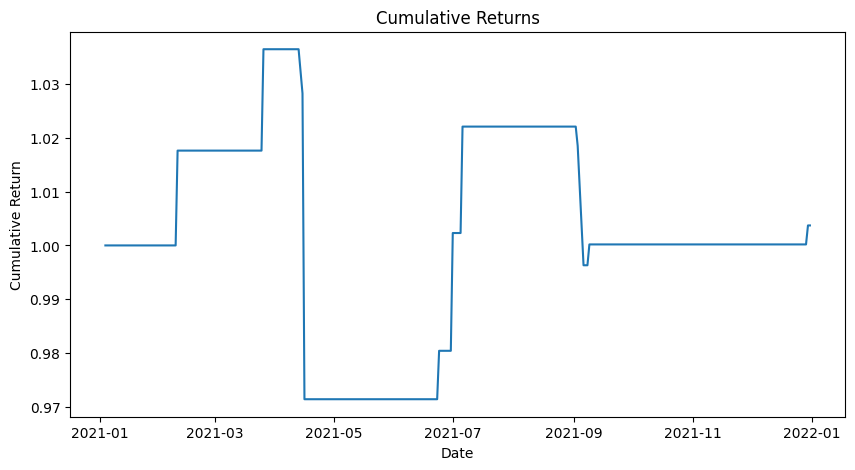

In [ ]:
strategy_returns = positions * returns[stock1] - positions * returns[stock2]

cumulative_returns = (1 + strategy_returns).cumprod()

individual_stock_returns = returns[stock1] - returns[stock2]

sharpe_ratio = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())

rolling_max = cumulative_returns.rolling(window=252, min_periods=1).max()
daily_drawdown = cumulative_returns / rolling_max - 1.0
max_drawdown = daily_drawdown.min()

plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

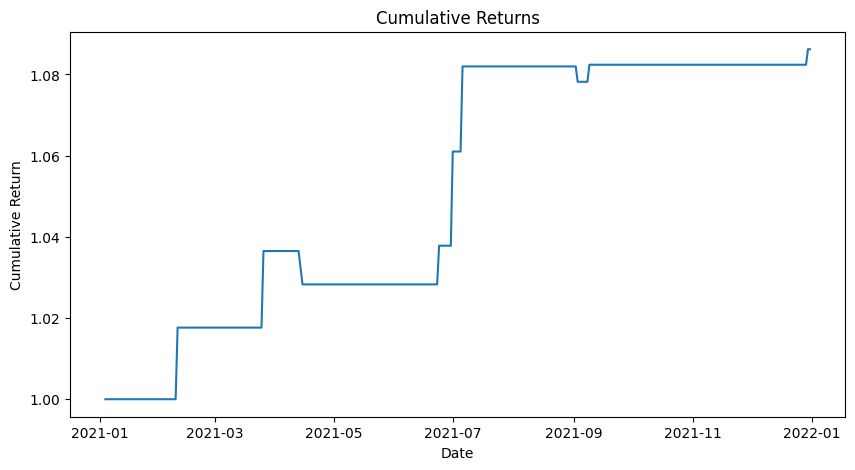

In [ ]:
# Initialize positions and signals
positions = pd.Series(0, index=spread.index)
signals = pd.Series(0, index=spread.index)
stop_loss_threshold = 0.02  # Set a 2% stop-loss threshold
take_profit_threshold = 0.02  # Set a 2% take-profit threshold
transaction_cost = 0.001  # Assume a transaction cost of 0.1%

# Generate signals based on entry and exit thresholds
signals[zscore > entry_threshold] = 1
signals[zscore < -entry_threshold] = -1
signals[np.abs(zscore) < exit_threshold] = 0

# Calculate positions based on signals
positions = signals.diff().shift(-1).fillna(0)

# Implement stop-loss and take-profit levels
current_position = 0
for i in range(1, len(positions)):
    if current_position == 0:
        if positions[i] == 1:
            current_position = 1
            entry_price = spread[i]
            stop_loss_price = entry_price * (1 - stop_loss_threshold)
            take_profit_price = entry_price * (1 + take_profit_threshold)
        elif positions[i] == -1:
            current_position = -1
            entry_price = spread[i]
            stop_loss_price = entry_price * (1 + stop_loss_threshold)
            take_profit_price = entry_price * (1 - take_profit_threshold)
    else:
        if current_position == 1 and spread[i] <= stop_loss_price:
            current_position = 0
            positions[i] = 0
        elif current_position == -1 and spread[i] >= stop_loss_price:
            current_position = 0
            positions[i] = 0
        elif current_position == 1 and spread[i] >= take_profit_price:
            current_position = 0
            positions[i] = 0
        elif current_position == -1 and spread[i] <= take_profit_price:
            current_position = 0
            positions[i] = 0

# Adjust positions for transaction costs
positions = positions * (1 - transaction_cost)

# Calculate daily returns of the strategy
strategy_returns = positions * returns[stock1] - positions * returns[stock2]

# Calculate cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod()

# Calculate daily returns of individual stocks for comparison
individual_stock_returns = returns[stock1] - returns[stock2]

# Calculate Sharpe ratio
sharpe_ratio = np.sqrt(252) * (strategy_returns.mean() / strategy_returns.std())

# Calculate maximum drawdown
rolling_max= cumulative_returns.rolling(window=252, min_periods=1).max()
daily_drawdown = cumulative_returns / rolling_max - 1.0
max_drawdown = daily_drawdown.min()

# Plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()



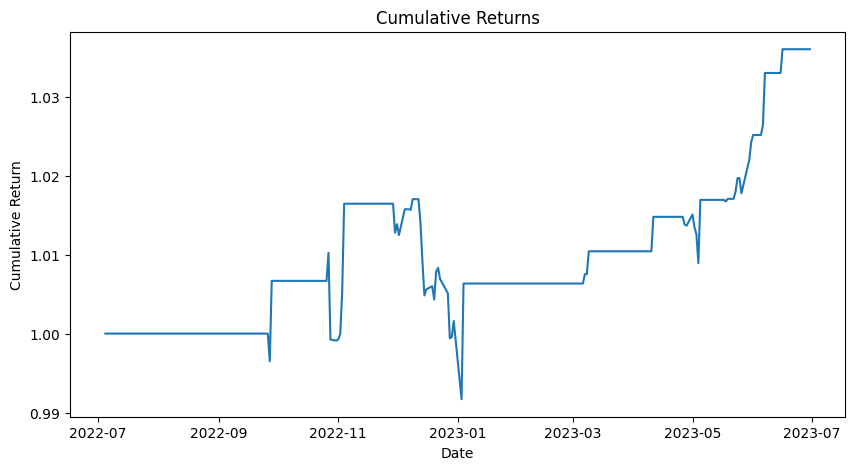

In [ ]:
# Initialize variables
capital = 1000000  # Initial capital
entry_threshold = 1.5  # Entry threshold for z-score
exit_threshold = 0.5  # Exit threshold for z-score
stop_loss = 0.02  # Stop-loss threshold
take_profit = 0.02  # Take-profit threshold
lookback_period = 60  # Lookback period for calculating z-score
position_size = 0.5  # Maximum position size as a percentage of capital

# Calculate z-score
zscore = (spread - spread.rolling(lookback_period).mean()) / spread.rolling(lookback_period).std()

# Initialize positions and signals
positions = pd.Series(0, index=spread.index)
signals = pd.Series(0, index=spread.index)

# Generate signals based on entry and exit thresholds
signals[(zscore > entry_threshold) & (positions.shift(1) == 0)] = -1
signals[(zscore < -entry_threshold) & (positions.shift(1) == 0)] = 1
signals[(np.abs(zscore) < exit_threshold) & (positions.shift(1) != 0)] = 0

# Calculate positions based on signals and position size
positions = signals * position_size

# Implement stop-loss and take-profit levels
current_position = 0
entry_price = 0
stop_loss_price = 0
take_profit_price = 0
for i in range(len(positions)):
    if current_position == 0:
        if positions[i] == 1:
            current_position = 1
            entry_price = spread[i]
            stop_loss_price = entry_price * (1 - stop_loss)
            take_profit_price = entry_price * (1 + take_profit)
        elif positions[i] == -1:
            current_position = -1
            entry_price = spread[i]
            stop_loss_price = entry_price * (1 + stop_loss)
            take_profit_price = entry_price * (1 - take_profit)
    else:
        if current_position == 1 and (spread[i] >= stop_loss_price or spread[i] <= take_profit_price):
            current_position = 0
            positions[i] = 0
        elif current_position == -1 and (spread[i] <= stop_loss_price or spread[i] >= take_profit_price):
            current_position = 0
            positions[i] = 0

# Calculate trade returns
trade_returns = positions.shift(1) * (spread - spread.shift(1))

# Calculate cumulative returns
cumulative_returns = (1 + trade_returns).cumprod()
portfolio_value = capital * (1 + trade_returns).cumprod()

# Calculate other performance metrics
returns = trade_returns.mean()
std_dev = trade_returns.std()
sharpe_ratio = (returns / std_dev) * np.sqrt(252)
max_drawdown = (portfolio_value / portfolio_value.cummax() - 1).min()

# Plot cumulative returns
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns)
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()
